## Summary
- This notebook will contain a Multi Optimalization Evolutionary Algorithm solution for critical node detection.
- We will use the pygmo library which can handle MOEA easily.
- We are trying to find critical nodes in multilayer networks

We have defined two different multi objectives 

1. v1:
   1. Maximalize number of components
   2. Minimalize number of inter layer connections
2. v2
   1. Minimalize the size of the largest component
   2. Minimalize number of inter layer connections

In [1]:
# %reset

In [1]:
%matplotlib widget
%run MultilayerScaleFreeNetworkGenerator.ipynb
import pymnet as pm
import numpy as np
import matplotlib.pyplot as plt
import pygmo as pg
import pandas as pd

from random import randrange, random, sample
import os
import copy
import math

# Small hack for the pygmo.archipelago() call
# TODO(nkis): check if this is correct
__spec__ = "ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>)"

# The MOA algorithm which we use
current_moa_version = 1

### Pymnet custom functions
- The following part below contains some functions which work as an extension to the pymnet MultiLayerNetwork class

In [3]:
def get_multilayer_network_from_folder(data_folder, print_some_basic_information_about_graph = False):
    input_file = None
    for f in os.listdir(data_folder):
        if "multiplex" in f:
            input_file = "{}/{}".format(data_folder, f)
            break
    if input_file is None:
        raise "Could not find input multiplex file in folder: " + data_folder
    g = pm.MultilayerNetwork(aspects=1, fullyInterconnected=False)
    with open(input_file) as f:        
        for line in f:
            line_data = np.array(line.replace("\n","").replace("\r\n","").split(" ")).astype(float).astype(int)
            source_layer = line_data[0]
            source_node = line_data[1]
            target_node = line_data[2]
            target_layer = line_data[3]
            # g[i, j, s, r] -> edge between nodes i and j and layers s and r
            g[source_node, target_node, source_layer, target_layer] = 1
    if print_some_basic_information_about_graph:
        print(f"Number of inter edges in the original graph: {get_number_of_inter_edges_in_pymnet_graph(g)}")
        print(f"Number of componenets in the original graph: {get_number_of_components_in_pymnet_graph(g)}")
        print(f"Size of the largest component in original graph: {get_size_of_largest_component_in_pymnet_graph(g)}")
        print(f"Number of layers in original graph: {len([layer for layer in g.iter_layers()])}")
    return g

def deep_copy_pymnet_graph(g : pm.MultilayerNetwork):
    h = pm.MultilayerNetwork(aspects=1, fullyInterconnected=False)
    for layer in g.iter_layers():
        for node in g.iter_nodes(layer):
            for neighbors in g._iter_neighbors((node, layer)):
                neighbor_node = neighbors[0]
                neighbor_layer = neighbors[1]
                h[node, neighbor_node, layer, neighbor_layer] = 1
    return h

# Will remove a node-layer from a graph
def remove_node_from_pymnet_graph(g : pm.MultilayerNetwork, node, layer):    
    to_remove_nodes = np.array([])
    to_remove_layers = np.array([])
    for neigbors in g._iter_neighbors((node, layer)):
        # neigbor_node = neigbors[0]
        # neigbor_layer = neigbors[1]
        to_remove_nodes = np.append(to_remove_nodes, [neigbors[0]])
        to_remove_layers = np.append(to_remove_layers, [neigbors[1]])
    for i in range(0, len(to_remove_nodes)):        
        neigbor_node = to_remove_nodes[i]
        neigbor_layer = to_remove_layers[i]
        g[node, neigbor_node, layer, neigbor_layer] = 0
        g[neigbor_node, node, neigbor_layer, layer] = 0
    # Based on the pymnet source code, this way we can remove a node
    # IMPORTANT: can be used ONLY for our type of pm.MultilayerNetwork(aspects=1, fullyInterconnected=False)
    try:
        del g._net[(node, layer)]        
    except KeyError:
        pass
        # print("Warning: node {} on layer {} does not exist. Was it already removed?".format(node, layer))
        # print(f"Type in python of node: {type(node)} ; type in python of layer: {type(layer)}")
    try:
        g._nodeToLayers[node].remove(layer)
    except KeyError:
        pass
    try:
        g._layerToNodes[layer].remove(node)
    except KeyError:
        pass
        
        
# Will return the number of connected components in a graph        
def get_number_of_components_in_pymnet_graph(g : pm.MultilayerNetwork):    
    node_layer_visited = set()
    count_of_components = 0    
    for layer in g.iter_layers():
        for node in g.iter_nodes(layer):
            key = "{}-{}".format(node, layer)
            if key in node_layer_visited:
                continue
            _visit_neigbors(g, node, layer, node_layer_visited)
            count_of_components += 1
    return count_of_components

# Will visit all neighbors of node-layer and add those neighbors to node_layer_visited
# This is a recursive function - depth walk of a graph??
def _visit_neigbors(g : pm.MultilayerNetwork, node, layer, node_layer_visited):
    key = "{}-{}".format(node, layer)
    if key in node_layer_visited:
        return
    node_layer_visited.add(key)
    for neigbors in g._iter_neighbors((node, layer)):
        neigbors_node = neigbors[0]
        neigbors_layer = neigbors[1]
        _visit_neigbors(g, neigbors_node, neigbors_layer, node_layer_visited)
    return node_layer_visited

# Will return the size of the largest component in a graph
def get_size_of_largest_component_in_pymnet_graph(g : pm.MultilayerNetwork):
    node_layer_visited = set()
    previous_set_of_node_layer_visited = set()
    count_of_components = 0
    max_component_size = -1
    for layer in g.iter_layers():
        for node in g.iter_nodes(layer):
            key = "{}-{}".format(node, layer)
            if key in node_layer_visited:
                continue
            _visit_neigbors(g, node, layer, node_layer_visited)
            current_set_of_node_layer_visited = node_layer_visited - previous_set_of_node_layer_visited
            if len(current_set_of_node_layer_visited) > max_component_size:
                max_component_size = len(current_set_of_node_layer_visited)
            previous_set_of_node_layer_visited = node_layer_visited.copy()
            count_of_components += 1
    return max_component_size

# Will return the number of inter layer edges in the graph `g`
def get_number_of_inter_edges_in_pymnet_graph(g : pm.MultilayerNetwork):
    inter_layer_edge_count = 0
    for layer in g.iter_layers():
        for node in g.iter_nodes():
            for neigbors in g._iter_neighbors((node, layer)):
                neigbor_layer = neigbors[1]
                if layer != neigbor_layer:
                    inter_layer_edge_count += 1
    if inter_layer_edge_count/2 != inter_layer_edge_count//2:
        print("CHEck thiS OUT!!!")
    # Since we count the neighbors twice, we divide the result with 2
    return inter_layer_edge_count//2

# Will remove all nodes which are in an np array in a format of [node, layer, node, layer, ...]
def remove_nodes_from_pymnet_graph(g, x : np.array):       
    # We will create new graph as a full copy and remove these nodes
    nodes = x[0::2]
    layers = x[1::2]        
   
    modified_g = deep_copy_pymnet_graph(g)
    for i in range(0, len(nodes)):
        node = nodes[i]
        layer = layers[i]
        remove_node_from_pymnet_graph(modified_g, node, layer)

    return modified_g

def get_total_number_of_nodes_in_pymnet_graph(g : pm.MultilayerNetwork):
    ret = 0
    for layer in g.iter_layers():
        for node in g.iter_nodes(layer):
            ret += 1
    return ret

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-66615b95dda8>", line 26, in <cell line: 26>
    def deep_copy_pymnet_graph(g : pm.MultilayerNetwork):
NameError: name 'pm' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", 

### Pygmo custom problem class <b>pygmo_problem_critical_node<b>

In [9]:
# This class will search for an array which contains [node, node, node, ...]
# that are the potential critical nodes
# Since the pygmo uses np arrays, we will renumber the whole graph
# We will search in the space of [0, totalNumberOfNodes] and will have a translation
# function which converts [node, layer] pairs into a single digit

# We assume that the layers and nodes are numerical and that they in a specific range
class pygmo_problem_critical_node():
    # @param g - the graph for which we want to solve the problem
    # @param number_of_critical_nodes_to_find - how many critical nodes are we searching for
    # @param check_for_duplicates - should we exclude solutions which contain the same node multiple times?
    def __init__(self, g : pm.MultilayerNetwork, number_of_critical_nodes_to_find, moa_version = 1, check_for_duplicates = False, truncate_fitness_values=False):
        self.g = g
        self.dim = number_of_critical_nodes_to_find
        self.moa_version = moa_version
        self.total_number_of_nodes = get_total_number_of_nodes_in_pymnet_graph(self.g)
        self.check_for_duplicates = check_for_duplicates
        self.translation_dict = None
        self.number_of_components = get_number_of_components_in_pymnet_graph(g)
        self.number_of_inter_edges = get_number_of_inter_edges_in_pymnet_graph(g)
        self.size_of_largest_component = get_size_of_largest_component_in_pymnet_graph(g)
        self.truncate_fitness_values = truncate_fitness_values
        
    def translate_moa_to_node_layer_pair(self, x):
        if self.translation_dict is None:
            self.build_translation_dict()
        ret = []
        for value in x:
            translated_value = self.translation_dict[value]
            node_layer = translated_value.split("-")
            node = int(node_layer[0])
            layer = int(node_layer[1])
            ret.append(node)
            ret.append(layer)
        return ret
            
    def build_translation_dict(self):
        i = 0
        self.translation_dict = dict()
        for layer in self.g.iter_layers():
            for node in self.g.iter_nodes(layer):
                key = f"{node}-{layer}"
                self.translation_dict[i] = key
                i += 1
        
    def fitness(self, x):
        if self.check_for_duplicates and not self.is_input_valid(x):
            if self.moa_version == 1:
                return [-number_of_components, number_of_inter_edges]
            else:
                return [size_of_largest_component, number_of_inter_edges]
        
        if self.truncate_fitness_values:
            for i in range(len(x)):
                x[i] = math.trunc(x[i])
        
        translated_x = self.translate_moa_to_node_layer_pair(x)
        
        ret = None
        if self.moa_version == 1:
            ret = self.fitness_v1(translated_x)
        elif self.moa_version == 2:
            ret = self.fitness_v2(translated_x)
        else:
            raise Exception("Invalid multi objective algorithm version: {}".format(self.moa_version))
        
        # print(ret)
        return ret
        
    def is_input_valid(self, x):
        # Will return False if there are duplicates in the array
        values = {}
        for i in range(0, len(x)):
            if x[i] not in values:
                values[x[i]] = 0
            values[x[i]] += 1
        found_duplicates = False
        for i in values:
            if values[i] > 1:
                found_duplicates = True
                break
        return not found_duplicates
        
    # The fitness function of MOA.v1
    def fitness_v1(self, translated_x):
        modified_g = remove_nodes_from_pymnet_graph(self.g, translated_x)
        number_of_components = get_number_of_components_in_pymnet_graph(modified_g)
        number_of_inter_edges = get_number_of_inter_edges_in_pymnet_graph(modified_g)
        
        # Max number of components and min number of inter connections
        ret = [-number_of_components, number_of_inter_edges]
        return ret
    
    # The fitness function of MOA.v2
    def fitness_v2(self, translated_x):
        modified_g = remove_nodes_from_pymnet_graph(self.g, translated_x)
        size_of_largest_component = get_size_of_largest_component_in_pymnet_graph(modified_g)
        number_of_inter_edges = get_number_of_inter_edges_in_pymnet_graph(modified_g)
        
        # Min size of the largest component and min number of inter connections
        ret = [size_of_largest_component, number_of_inter_edges]
        return ret
    
    # We are doing a 2 objective optimization problem
    def get_nobj(self):
        return 2
    
    # See description inside this function
    def get_bounds(self):
        bounds = (
            # Lower bounds
            [0] * self.dim,
            # Upper bounds
            [self.total_number_of_nodes - 1] * self.dim
        )
        return bounds
    
    # Should return an integer which equals the length of the get_bounds function lower (or upper) bounds array
    def get_nix(self):
        return self.dim
    
    def get_largest_node_number(self):
        return max([node for node in self.g.iter_nodes()])
    
    def get_lowest_node_number(self):
        return min([node for node in self.g.iter_nodes()])    

### Pygmo helpers
- The following part contains some helper functions written to ease the work with pygmo multi objective results

In [102]:
# archi.get_champions_f()
def get_max_f_and_x(archi : pg.archipelago, moa_version = 1): 
    if moa_version < 1 or moa_version > 2:
        raise Exception("Invalid moa_version: {}".format(moa_version))
        
    max_f = np.array([np.inf, np.inf])
    max_x = None
    max_found = False
    for island in archi:
        pop = island.get_population()
        population_f = pop.get_f()
        population_x = pop.get_x()
        i = 0
        n = len(population_f)
        for i in range(0, n):
            f = population_f[i]
            x = population_x[i]
            # If by any chance we would have no solution in this population, we skip it
            if f[0] == -np.inf or f[0] == np.inf or f[1] == -np.inf or f[1] == np.inf:
                continue
            if f[0] <= max_f[0] and f[1] <= max_f[1]:
                max_f = f
                max_x = x
                max_found = True
    if not max_found:
        print("Error: max f for any island in the archipelago could not be found. This usually means that useless inputs were generated by the MOA")
    return (max_f, max_x)

def get_max_f_and_x_for_each_island(archi : pg.archipelago, moa_version = 1): 
    if moa_version < 1 or moa_version > 2:
        raise Exception("Invalid moa_version: {}".format(moa_version))
        
    max_f_values = np.empty([0,2])
    max_x_values = None
    max_found = False
    for island in archi:
        max_f = np.array([np.inf, np.inf])
        max_x = None
        pop = island.get_population()
        population_f = pop.get_f()
        population_x = pop.get_x()
        
        if max_x_values is None:
            number_of_critical_nodes_to_find = len(population_x[0])
            max_x_values = np.empty([0, number_of_critical_nodes_to_find])
        
        i = 0
        n = len(population_f)
        for i in range(0, n):
            f = population_f[i]
            x = population_x[i]
            # If by any chance we would have no solution in this population, we skip it
            if f[0] == -np.inf or f[0] == np.inf or f[1] == -np.inf or f[1] == np.inf:
                continue
            if f[0] <= max_f[0] and f[1] <= max_f[1]:
                max_f = f
                max_x = x
                max_found = True
        max_x_values = np.vstack([max_x_values, max_x])
        max_f_values = np.vstack([max_f_values, max_f])
    if not max_found:
        print("Error: max f for any island in the archipelago could not be found. This usually means that useless inputs were generated by the MOA")
    return (max_f_values, max_x_values)

def plot_pareto_like_front(archi : pg.archipelago = None, all_f_values : np.array = None, moa_version = 1):
    if moa_version < 1 or moa_version > 2:
        raise Exception(f"Invalid moa_version: {moa_version}. Should be 1 or 2")
    f1_descr = "number_of_components"
    f2_descr = "number_of_inter_edges"
    if moa_version == 2:
        f1_descr = "size_of_largest_component"
        
    if archi is not None and all_f_values is None:    
        all_f_values = np.empty([0,2])
        for island in archi:
            f = island.get_population().get_f()     
            all_f_values = np.concatenate([all_f_values, f], axis = 0)
    elif archi is None and all_f_values is not None:
        pass
    else:
        raise Exception("archi or all_f_values parameter must be none and the other not to run this function")
    
    if moa_version == 1:
        all_f_values[:, 0] *= -1
        
    # Remove duplicates so we make it easier for the plot
    all_f_values = np.unique(all_f_values, axis=0)
    # Plot
    df = pd.DataFrame(all_f_values)
    ax = df.plot(kind='scatter', x=0, y=1, grid=True)
    ax.set_xlabel(f1_descr)
    ax.set_ylabel(f2_descr)
    plt.show()

### Random stuff for drawing

In [6]:
def get_node_color_dict(g, critical_nodes):
    ret = {}
    for layer in g.iter_layers():
        for node in g.iter_nodes(layer):
            color = (0,0,0)
            if (node, layer) in critical_nodes:
                color = (1,0,0)
            ret[(node, layer)] = color
    return ret

## Playground

In [7]:
# plt.close("all")
# current_moa_version = 1
# g = get_multilayer_network_from_folder("Data/Padgett-Florentine-Families", True)
# prob = pg.problem(pygmo_problem_critical_node(g, number_of_critical_nodes_to_find=2, moa_version=current_moa_version))
# algo = pg.de(gen=2000)
# archi = pg.archipelago(n = 10, pop_size = 20, algo = algo, prob = prob)
# archi.evolve()
# archi.wait()

# for island in archi:
#     population = island.get_population().get_x()
#     hv = pg.hypervolume(population)
#     ref_point = hv.refpoint(offset=0.1)
#     print(hv.compute(ref_point))
    
    
#     for f in population_f:
#         if f[0] != -np.inf or f[1] != np.inf:
#             print(f"f: {f}")
# f, x = get_max_f_and_x(archi, moa_version=current_moa_version)

# print("f = {} ; x = {}".format(f, x))
# critical_nodes = []
# for i in range(0, len(x), 2):
#     critical_nodes.append((int(x[i]), int(x[i+1])))
# node_color_dict = get_node_color_dict(g, critical_nodes)
# print(critical_nodes)
# pm.draw(g, layout="circular", nodeColorDict = node_color_dict);

# modified_g = remove_nodes_from_pymnet_graph(g, x)
# pm.draw(modified_g, layout="circular");

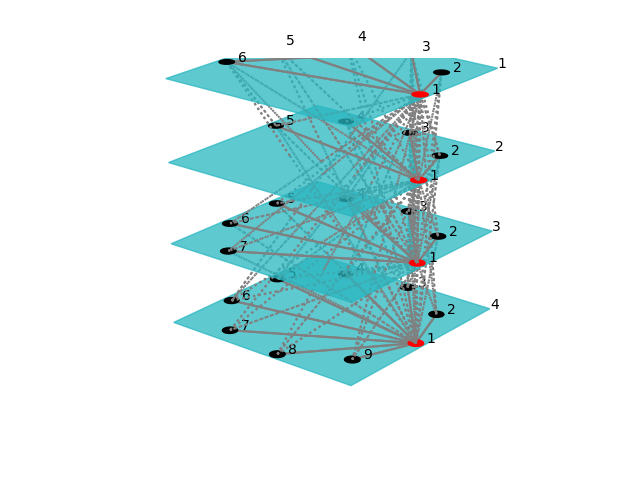

In [104]:
# g, node_color_dict = build_graph(
#     spread_critical_nodes = True,
#     number_of_layers = 4,
#     min_number_of_nodes_on_each_layer = 5, 
#     max_number_of_nodes_on_each_layer = 11,
#     number_of_critical_nodes_in_total = 4,
#     max_number_of_critical_nodes_on_each_layer = 1)

# pm.draw(g, layout="circular", nodeColorDict = node_color_dict);

Number of components in original graph 1
Number of inter edges in original graph 80
Size of the largest component in original graph 27


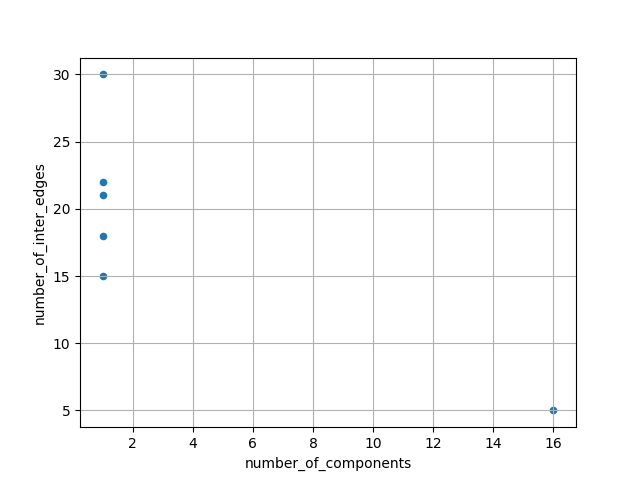

In [162]:
# plt.close("all")
# number_of_components = get_number_of_components_in_pymnet_graph(g)
# number_of_inter_edges = get_number_of_inter_edges_in_pymnet_graph(g)
# size_of_largest_component = get_size_of_largest_component_in_pymnet_graph(g)
# print("Number of components in original graph {}".format(number_of_components))
# print("Number of inter edges in original graph {}".format(number_of_inter_edges))
# print("Size of the largest component in original graph {}".format(size_of_largest_component))

# # User defined problem
# udp = pygmo_problem_critical_node(g, number_of_critical_nodes_to_find=4, moa_version=current_moa_version, check_for_duplicates=False, truncate_fitness_values=False)
# prob = pg.problem(udp)
# algo = pg.nsga2(gen=50)
# archi = pg.archipelago(n = 8, pop_size = 12, algo = algo, prob = prob)
# archi.evolve()
# archi.wait_check()
# # f, x = get_max_f_and_x(archi, current_moa_version)
# # x = udp.translate_moa_to_node_layer_pair(x)

# # print("f = {} ; x = {}".format(f, x))
# plot_pareto_like_front(archi=archi, moa_version=current_moa_version)
# # critical_nodes = []
# # for i in range(0, len(x), 2):
# #     critical_nodes.append((int(x[i]), int(x[i+1])))
# # node_color_dict_new = get_node_color_dict(g, critical_nodes)
# # print(critical_nodes)

# # pm.draw(g, layout="circular", nodeColorDict = node_color_dict_new)

# # # modified_g = remove_nodes_from_pymnet_graph(g, x)
# # # pm.draw(modified_g, layout="circular");

# # # # g2 = remove_nodes_from_pymnet_graph(g, [1, 1, 1, 2])
# # # # pm.draw(g2, layout="circular");
# # # # number_of_components = get_number_of_components_in_pymnet_graph(g2)
# # # # number_of_inter_edges = get_number_of_inter_edges_in_pymnet_graph(g2)
# # # # size_of_largest_component = get_size_of_largest_component_in_pymnet_graph(g2)
# # # # print("Number of components in original graph {}".format(number_of_components))
# # # # print("Number of inter edges in original graph {}".format(number_of_inter_edges))
# # # # print("Size of the largest component in original graph {}".format(size_of_largest_component))
# # "END"